# <font size=35 color=lightgreen>** Sentiment API **<font>
---

### <font size=12 color=lightgreen>Configuración Inicial (Librerías)</font>

#### 1. Procesamiento y Manipulación de Datos
* **`pandas`**
    * Nos ayuda con la manipulación y análisis de datos estructurados.
    * Carga el dataset (CSV), gestiona el DataFrame y permite filtrar o limpiar registros.
* **`numpy`**
    * Realiza las operaciones matemáticas y manejo de arrays eficientes.
    * Soporte numérico fundamental para las transformaciones vectoriales de los textos.

#### 2. Visualización y Análisis Exploratorio

* **`matplotlib.pyplot`**
    * Generación de gráficos estáticos.
    * Visualización básica de la distribución de clases (Positivo vs. Negativo).
* **`seaborn`**
    * Visualización de datos estadísticos avanzada.
    * Generación de matrices de confusión y gráficos de distribución estéticos para la presentación.

#### 3. Procesamiento de Lenguaje Natural (NLP) y Limpieza

* **`re`** (Regular Expressions)
    * Manejo de expresiones regulares.
    * Eliminación de ruido en el texto: URLs, menciones (@usuario), hashtags (#) y caracteres especiales no alfanuméricos.
* **`string`**
    * Constantes de cadenas comunes.
    * Provee listas estándar de signos de puntuación para su eliminación eficiente.

#### 4. Modelado y Machine Learning (Core)

* **`scikit-learn`**
    * Biblioteca principal de Machine Learning.
    * **`TfidfVectorizer`**: Transforma el texto limpio en vectores numéricos.
    * **`LogisticRegression`**: Algoritmo de clasificación supervisada.
    * **`metrics`**: Cálculo de precisión, recall y F1-score.
    * **`Pipeline`**: Encapsulamiento de los pasos de transformación y predicción.

#### 5. Persistencia e Integración
Herramientas para conectar el modelo con el Backend.

* **`joblib`**
    * Serialización eficiente de objetos Python.
    * Exportar (`dump`) el pipeline entrenado a un archivo `.joblib` y cargarlo (`load`) en la API para realizar predicciones.
* **`fastapi` & `uvicorn`**
    * Framework web moderno de alto rendimiento.
    * Exponer el modelo entrenado como un microservicio REST (endpoint `/predict`) para ser consumido por el Backend en Java.




---



### <font size=16  color=lightgreen> Importando librerías <font>



In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import string
import chardet
import uvicorn
import sklearn
import fastapi
import joblib
import nltk
import unicodedata
import urllib.request
from io import StringIO
import urllib.response
import os
from pathlib import Path
from datetime import datetime
import warnings


### <font size = 8 color="lightgreen">Importación de los datasets<font>

#### **Función importación dataset**

In [333]:
def importar_dataset(url):
    """
    Importa dataset desde URL detectando encoding automáticamente.
    """
    try:
        # 1. Descargar contenido una sola vez
        with urllib.request.urlopen(url) as response:
            content = response.read()
        
        # 2. Detectar encoding
        result = chardet.detect(content)
        encoding = result['encoding']
        print(f"🔍 Encoding detectado: {encoding} (confianza: {result['confidence']:.2%})")
        
        # 3. Decodificar y cargar en DataFrame
        decoded_content = content.decode(encoding, errors='replace')
        data = pd.read_csv(StringIO(decoded_content), sep=';')
        
        print("✅ Archivo cargado correctamente")
        print(f"📊 Tamaño del dataset: {data.shape}")
        print("\n🔍 Muestra aleatoria (3 registros):")
        print(data.sample(3))
        
        return data
        
    except urllib.error.URLError as e:
        print(f"❌ Error de URL: {e}")
        return None
    except pd.errors.ParserError as e:
        print(f"❌ Error al parsear CSV: {e}")
        return None
    except Exception as e:
        print(f"❌ Error inesperado: {type(e).__name__}: {e}")
        return None

#### **Dataset1: sentimentdataset_es.csv**

In [334]:
df1_raw = importar_dataset("https://github.com/ml-punto-tech/sentiment-api/raw/refs/heads/dev/data-science/datasets/datasets-origin/sentimentdataset_es.csv")


🔍 Encoding detectado: Windows-1252 (confianza: 72.97%)
✅ Archivo cargado correctamente
📊 Tamaño del dataset: (732, 15)

🔍 Muestra aleatoria (3 registros):
     Unnamed: 0.1  Unnamed: 0  \
243           106         108   
308           698         702   
279           461         465   

                                                  Text   Sentiment  \
243  Emoción por un viaje por carretera de fin de s...  Excitación   
308  Enfrentando el rechazo de la universidad de su...    Tristeza   
279  En el vacío del dolor, suenan los ecos de una ...    Angustia   

            Timestamp                        User   Platform  \
243  02-03-2023 16:45                RoadTripper2    Twitter   
308  25-09-2023 20:45  CollegeRejectionHighSchool   Facebook   
279  10-07-2022 22:15                LoveSongEcho  Instagram   

                              Hashtags  Retweets  Likes      Country  Year  \
243  #Emoción #AventuraDeFin De Semana        25     50        India  2023   
308  #CollegeDream

#### **Dataset2: sentiment_analysis_dataset.csv**

In [335]:
df2_raw = importar_dataset("https://raw.githubusercontent.com/ml-punto-tech/sentiment-api/refs/heads/feature/data-science-marely/data-science/datasets/datasets-origin/sentiment_analysis_dataset.csv")

🔍 Encoding detectado: Windows-1252 (confianza: 73.00%)
✅ Archivo cargado correctamente
📊 Tamaño del dataset: (2540, 3)

🔍 Muestra aleatoria (3 registros):
                                                  texto  label sentimiento
682   Felicidad Es un viaje lejano mano con mano La ...      0    negativo
2090  Escuchando Los Tenores de ADN. Estoy estupefac...      1     neutral
1241  Para entender el mundo, lee.  Para entenderte ...      2    positivo


<font color='lightgreen' size=12>Filtrar datasets</font>

In [336]:
# Función filtrar dataset
def filtrar_dataset(data):
    data_filtro = data[['texto', 'sentimiento']]
    data_filtro = data_filtro[data_filtro['texto'].str.strip() != ""]
    print(data_filtro.sample(5))
    return data_filtro

# Reemplazar nombre columnas Text por texto, Sentiment por sentimiento
df1_raw.rename({'Text':'texto', 'Sentiment':'sentimiento'}, axis=1, inplace=True)
df1_filtrado = filtrar_dataset(df1_raw)
df2_filtrado = filtrar_dataset(df2_raw)

                                                 texto     sentimiento
725  Vagando por el desierto de la soledad, cada pa...         Soledad
647  Sentirse empoderado después de conquistar una ...  Empoderamiento
488  Llevar bocadillos a clase como un profesional....        Positivo
178  Curiosidad que despiertan los misterios de un ...      Curiosidad
431  La bondad presenciada hoy restableció mi fe en...      Amabilidad
                                                  texto sentimiento
2300             atake d chochoneria y feliz espontaneo    positivo
2474  cómo Leandro N tengo calle y te desarmo sin qu...    positivo
653   a tu pai lo tengo harto porque siempre llego e...    negativo
1297   Estoy tan descansado que necesito algo que hacer    positivo
218   Especialmente titubeante Pagni. Le salva las p...    negativo


### <font size= 12 color="lightgreen" >Explorando los datasets<font>

In [337]:
# Crear función para explorar datasets
def explorar_dataset(data):
    print('Filas: ' + str(data.shape[0]))
    print('Columnas: ' + str(data.shape[1]))
    print('\nColumnas: \n' + str(data.columns.tolist()))
    print('\nTipo de datos: \n' + str(data.dtypes))
    print('\nValores nulos: \n' + str(data.isnull().sum()))
    print('\nMuestra aleatoria (5 registros): \n' + str(data.sample(5)))

#### **Explorando Data1**

In [338]:
explorar_dataset(df1_filtrado)

Filas: 732
Columnas: 2

Columnas: 
['texto', 'sentimiento']

Tipo de datos: 
texto          object
sentimiento    object
dtype: object

Valores nulos: 
texto          0
sentimiento    0
dtype: int64

Muestra aleatoria (5 registros): 
                                                 texto sentimiento
562  Pasé la tarde en un museo, fingiendo ser culto...  Curiosidad
26   Abrazado por el amanecer Esperanza, un jardine...   Esperanza
711  Una escapada lúdica al carnaval de la vida, ri...    Positivo
342  Euforia tras un reencuentro sorpresa con un am...     Elación
333  Esperanzado en el potencial de crecimiento per...   Esperanza


#### **Explorando data2**

In [339]:
explorar_dataset(df1_filtrado)

Filas: 732
Columnas: 2

Columnas: 
['texto', 'sentimiento']

Tipo de datos: 
texto          object
sentimiento    object
dtype: object

Valores nulos: 
texto          0
sentimiento    0
dtype: int64

Muestra aleatoria (5 registros): 
                                                 texto sentimiento
713  Una escapada lúdica al carnaval de la vida, ri...    Positivo
728  Viaje por carretera de fin de semana para expl...    Positivo
708  Una amarga experiencia se convirtió en una val...    Amargura
631  Se quedó sin bocadillos durante una maratón de...     Neutral
276  En el torneo de golf, la precisión y la concen...    Positivo


### <font size=12 color=lightgreen>Limpiar textos</font>

#### **Función para limpieza de textos**

In [340]:
def limpiar_texto_para_sentimientos(texto):
    """
    Normaliza texto español preservando ñ y eliminando tildes.
    NO convierte a minúsculas para preservar intensidad emocional.
    """
    # Verifica si la entrada no es una cadena. Si no lo es, devuelve una cadena vacía.
    if not isinstance(texto, str):
        return ""

    # 1. Normaliza el texto para separar los caracteres base de sus diacríticos (ej., tildes).
    texto = unicodedata.normalize('NFD', texto)

    # 2. Reemplaza temporalmente las 'ñ' y 'Ñ' con marcadores especiales para preservarlas
    # durante la eliminación de diacríticos.
    texto = texto.replace('n\u0303', '@@@N_TILDE@@@')
    texto = texto.replace('ñ', '@@@N_TILDE@@@')
    texto = texto.replace('N\u0303', '@@@N_TILDE_MAYUS@@@')
    texto = texto.replace('Ñ', '@@@N_TILDE_MAYUS@@@')

    # 3. Elimina los caracteres diacríticos (como las tildes) del texto.
    texto = ''.join(
        char for char in texto
        if not unicodedata.combining(char)
    )

    # Restaura las 'ñ' y 'Ñ' utilizando los marcadores temporales.
    texto = texto.replace('@@@N_TILDE@@@', 'ñ')
    texto = texto.replace('@@@N_TILDE_MAYUS@@@', 'Ñ')

    # Variable para almacenar el resultado de la limpieza.
    resultado = texto
    chars = []

    # Itera sobre cada caracter en el resultado y añade solo los caracteres imprimibles a una lista.
    # Los caracteres no imprimibles (como los de control) son reemplazados por un espacio.
    for char in resultado:
        if char.isprintable():
            chars.append(char)
        else:
            chars.append(' ')
    resultado = ''.join(chars)

    # Elimina URLs que terminan en "..." (posibles URLs rotas).
    resultado = re.sub(r'https?://[^\s]*\.\.\.', '[URL_ROTA]', resultado)
    resultado = re.sub(r'www\.[^\s]*\\.\\.\\.', '[URL_ROTA]', resultado)

    # Normaliza los espacios múltiples a uno solo y elimina espacios al inicio y final.
    resultado = ' '.join(resultado.split())
    resultado = resultado.strip()

   

    # Devuelve el texto preprocesado.
    return resultado


In [341]:
# Lista de dataframes para procesar
dataframes = [
    (df1_filtrado, "Dataset 1"),
    (df2_filtrado, "Dataset 2")
]

resultados = {}

for df, nombre in dataframes:
    # Aplicar limpieza
    df['Texto_Limpio'] = df['texto'].apply(limpiar_texto_para_sentimientos)
    
    # Guardar copia limpia
    resultados[nombre] = df.copy()
    
    # Mostrar info
    print(f"\n📁 {nombre}")
    print(f"   Registros: {len(df):,}")
    print(f"   Muestra (3 textos):")
    print(df[['texto', 'Texto_Limpio']].sample(3))

# Asignar a variables originales
df1_clean = resultados["Dataset 1"]
df2_clean = resultados["Dataset 2"]


📁 Dataset 1
   Registros: 732
   Muestra (3 textos):
                                                 texto  \
620  Rodeado de los colores vibrantes de un jardín ...   
640  Sentir una sensación de plenitud después de al...   
86   Anticipando el estreno de una película muy esp...   

                                          Texto_Limpio  
620  Rodeado de los colores vibrantes de un jardin ...  
640  Sentir una sensacion de plenitud despues de al...  
86   Anticipando el estreno de una pelicula muy esp...  

📁 Dataset 2
   Registros: 2,540
   Muestra (3 textos):
                                                  texto  \
2094  Según el escritor caroreño Franklin Piña: "Uno...   
218   Especialmente titubeante Pagni. Le salva las p...   
234   Estoy nomas un poquito desconcertado por eso q...   

                                           Texto_Limpio  
2094  Segun el escritor caroreño Franklin Piña: "Uno...  
218   Especialmente titubeante Pagni. Le salva las p...  
234   Estoy nomas 

In [342]:
df1_clean.sample(3)

,texto,sentimiento,Texto_Limpio
96,Asistió a un concierto de jazz y se balanceó a...,Alegría,Asistio a un concierto de jazz y se balanceo a...
492,Los celos me consumen al ser testigo del éxito...,Negativo,Los celos me consumen al ser testigo del exito...
212,"Dividido entre emociones encontradas, una ambi...",Ambivalencia,"Dividido entre emociones encontradas, una ambi..."


In [343]:
df2_clean.sample(3)

,texto,sentimiento,Texto_Limpio
1090,si el pito empuja entonces pite,negativo,si el pito empuja entonces pite
142,Se me rompió el pantalon de lado a lado hijo d...,negativo,Se me rompio el pantalon de lado a lado hijo d...
1477,TENEMOS UN PRESIDENTE QUE ESTA MAS ATENTO DE H...,positivo,TENEMOS UN PRESIDENTE QUE ESTA MAS ATENTO DE H...


### <font size=12 color=lightgreen>Categorizar de sentimientos </font>

#### **Categorías Sentimientos**

In [344]:
# 1. Definimos las listas de sentimientos según su categoría
# Ver todos los sentimientos únicos para saber qué agrupar y ordenar alfabetizamente
sentimientos_unicos = sorted(df1_clean['sentimiento'].unique())
print(f"Total de sentimientos únicos: {len(sentimientos_unicos)}")
print(sentimientos_unicos)

# 2. SENTIMIENTOS POSITIVOS COMPLETOS (Bienestar, éxito, alegría, admiración)
positivos = [
    'Aceptación', 'Admiración', 'Adoración', 'Agradecido', 'Alegría', 'Amabilidad', 'Amor', 'Amistad', 'Apreciación', 'Armonía', 'Asombro', 'Cautivación', 'Celebración', 'Colorido', 'Confiado','Confianza', 'Contentamiento', 'Creatividad', 'Cumplimiento', 'Descubrimiento', 'Deslumbrar', 'Determinación', 'Disfrute','Diversión', 'Elegancia', 'Emoción', 'Empático', 'Empoderamiento',
    'Encantamiento', 'Energía', 'Entusiasmo', 'Esperanza', 'Euforia', 'Excitación', 'Felicidad', 'Grandeza', 'Gratitud', 'Inspiración', 'Inspirado', 'Intimidación', 'Juguetón', 'Logro','Maravilla', 'Melódico', 'Motivación', 'Optimismo', 'Orgullo',
    'Positividad', 'Positivo', 'Reconfortante', 'Resiliencia', 'Resplandor', 'Reverencia', 'Romance', 'Satisfacción', 'Serenidad','Ternura', 'Triunfo', 'Ánimo', 'Éxito','Elación','Éxtasis','positivo']
print(f'Sentimientos positivos: {len(positivos)}')

# 3. SENTIMIENTOS NEGATIVOS COMPLETOS (Dolor, ira, miedo, estrés, pérdida)
negativos = [
    'Abrumado', 'Aburrimiento', 'Aislamiento', 'Amargura', 'Angustia', 'Anhelo', 'Ansiedad', 'Aprensivo', 'Arrepentimiento', 'Asco',  'Decepción', 'Desamor', 'Desesperación', 'Despectivo', 'Devastado',
    'Dolor', 'Enojo', 'Entumecimiento', 'Envidia', 'Envidioso', 'Frustración', 'Frustrado', 'Lástima', 'Obstáculo', 'Malo', 'Melancolía', 'Miedo', 'Negativo', 'Odiar', 'Pena', 'Pérdida', 'Reflexión', 'Resentimiento', 'Soledad', 'Sufrimiento', 'Temeroso', 'Traición', 'Tristeza', 'Verguenza','negativo']
print(f'Sentimientos negativos: {len(negativos)}')

# 4. SENTIMIENTOS NEUTRALES (Estados ambiguos o contemplativos)
neutros = ['Ambivalencia', 'Curiosidad', 'Neutral','Sorpresa','Anticipación','neutral']
print(f'Sentimientos neutros: {len(neutros)}')

# Verificación del total
total_clasificados = len(positivos) + len(negativos) + len(neutros)
print(f'\n✅ Total clasificado: {total_clasificados}/106 sentimientos')
print(f'   - Positivos: {len(positivos)} ({len(positivos)/106*100:.1f}%)')
print(f'   - Negativos: {len(negativos)} ({len(negativos)/106*100:.1f}%)')
print(f'   - Neutros: {len(neutros)} ({len(neutros)/106*100:.1f}%)')
print(f'Total: {len(positivos) + len(negativos) + len(neutros)}')

# Verificar si existen elementos en las listas que no se encuentran en la lista sentimientos_unicos
for sentimiento in negativos + positivos + neutros:
    if sentimiento not in sentimientos_unicos:
        print(f"❌ Sentimiento no encontrado en el dataset: {sentimiento}")

# Verificar si todos los sentimientos del dataset están clasificados
for sentimiento in sentimientos_unicos:
    if sentimiento not in positivos + negativos + neutros:
        print(f"❌ Sentimiento no clasificado: {sentimiento}")


Total de sentimientos únicos: 106
['Abrumado', 'Aburrimiento', 'Aceptación', 'Admiración', 'Adoración', 'Agradecido', 'Aislamiento', 'Alegría', 'Amabilidad', 'Amargura', 'Ambivalencia', 'Amistad', 'Amor', 'Angustia', 'Anhelo', 'Ansiedad', 'Anticipación', 'Apreciación', 'Aprensivo', 'Armonía', 'Arrepentimiento', 'Asco', 'Asombro', 'Cautivación', 'Celebración', 'Colorido', 'Confiado', 'Confianza', 'Contentamiento', 'Creatividad', 'Cumplimiento', 'Curiosidad', 'Decepción', 'Desamor', 'Descubrimiento', 'Desesperación', 'Deslumbrar', 'Despectivo', 'Determinación', 'Devastado', 'Disfrute', 'Diversión', 'Dolor', 'Elación', 'Elegancia', 'Emoción', 'Empoderamiento', 'Empático', 'Encantamiento', 'Energía', 'Enojo', 'Entumecimiento', 'Entusiasmo', 'Envidia', 'Envidioso', 'Esperanza', 'Euforia', 'Excitación', 'Felicidad', 'Frustración', 'Frustrado', 'Grandeza', 'Gratitud', 'Inspiración', 'Inspirado', 'Intimidación', 'Juguetón', 'Logro', 'Lástima', 'Malo', 'Maravilla', 'Melancolía', 'Melódico', 'Mi

#### **Función para categorizar sentimientos**

In [345]:
def categorizar_sentimiento(sentimiento, positivos, negativos, neutros):
    """
    Categoriza sentimientos solo si están en las listas definidas.
    Devuelve None para sentimientos no clasificados.
    """
    sent = str(sentimiento).strip().title()
    
    if sent in positivos:
        return 'positivo'
    elif sent in negativos:
        return 'negativo'
    elif sent in neutros:
        return 'neutral'
    else:
        # Devolvemos None para posterior filtrado
        return None


In [346]:
df1_clean.sample(3)

,texto,sentimiento,Texto_Limpio
66,"Al pasear por un museo histórico, el entusiast...",Neutral,"Al pasear por un museo historico, el entusiast..."
182,"Debajo de las luces de la ciudad, la bailarina...",Positivo,"Debajo de las luces de la ciudad, la bailarina..."
645,Sentirse bendecido por la comunidad solidaria ...,Positivo,Sentirse bendecido por la comunidad solidaria ...


In [347]:
df2_clean.sample(3)

,texto,sentimiento,Texto_Limpio
2443,"A ver, si tan valiente te reto a etiquetar a l...",positivo,"A ver, si tan valiente te reto a etiquetar a l..."
1132,Vosotros creéis que Carrero dio alguna volterE...,negativo,Vosotros creeis que Carrero dio alguna volterE...
1688,Me acabo de dar la frente contra la puerta de ...,positivo,Me acabo de dar la frente contra la puerta de ...


#### **Categorizar sentimientos**

In [348]:

df1_clean['Sentimiento_Final'] = df1_clean['sentimiento'].apply(
    lambda x: categorizar_sentimiento(x, positivos, negativos, neutros)
)

df1_categorized = df1_clean[df1_clean['Sentimiento_Final'].notna()].copy()

df2_clean['Sentimiento_Final'] = df2_clean['sentimiento'].apply(
    lambda x: categorizar_sentimiento(x, positivos, negativos, neutros)
)

df2_categorized = df2_clean[df2_clean['Sentimiento_Final'].notna()].copy()

print(f"✅ df1: {len(df1_categorized)} registros categorizados")
print(f"✅ df2: {len(df2_categorized)} registros categorizados")

✅ df1: 732 registros categorizados
✅ df2: 2540 registros categorizados


In [349]:
df1_clean.sample(3)

,texto,sentimiento,Texto_Limpio,Sentimiento_Final
179,Curiosidad que impulsa la exploración de lo de...,Curiosidad,Curiosidad que impulsa la exploracion de lo de...,neutral
146,"Comenzó a aprender bailes de salón, deslizándo...",Alegría,"Comenzo a aprender bailes de salon, deslizando...",positivo
256,"En el ámbito de la moda, el diseñador presenta...",Creatividad,"En el ambito de la moda, el diseñador presenta...",positivo


In [350]:
df2_clean.sample(3)

,texto,sentimiento,Texto_Limpio,Sentimiento_Final
2421,Ser constructivo significa construir. Y a vece...,positivo,Ser constructivo significa construir. Y a vece...,positivo
169,"""... Y con facilidad perdonaría su orgullo si ...",negativo,"""... Y con facilidad perdonaria su orgullo si ...",negativo
1298,no he descansado nads en esta semana,positivo,no he descansado nads en esta semana,positivo


### <font color=lightgreen size=12>Limpiar dataset unificado</font>

#### **Función limpieza dataset unificado**

In [351]:
def limpiar_dataset_unificado(data, verbose=True):
    """
    Limpia dataset unificado para análisis de sentimientos.
    
    Proceso:
    1. Identifica y elimina CONTRADICCIONES (textos con diferentes sentimientos)
    2. Elimina DUPLICADOS exactos (mismo texto, mismo sentimiento)
    3. Limpieza final (espacios vacíos, NaN)
    
    Args:
        data: DataFrame con 'Texto_Limpio' y 'Sentimiento_Final'
        verbose: Si True, muestra análisis detallado
    
    Returns:
        DataFrame limpio, sin duplicados ni contradicciones
    """
    
    if verbose:
        print("🧹 LIMPIANDO DATASET UNIFICADO")
        print("-" * 50)
        print(f"Registros iniciales: {len(data):,}")
        print(f"Textos únicos iniciales: {data['Texto_Limpio'].nunique():,}")
    
    # Hacer copia para no modificar original
    df = data.copy()
    
    # ===== 1. ELIMINAR CONTRADICCIONES (PRIMERO) =====
    if verbose:
        print(f"\n1. 🔍 BUSCANDO CONTRADICCIONES...")
    
    # Textos con más de un sentimiento diferente
    conteo_sentimientos = df.groupby('Texto_Limpio')['Sentimiento_Final'].nunique()
    textos_con_contradiccion = conteo_sentimientos[conteo_sentimientos > 1].index.tolist()
    
    if textos_con_contradiccion:
        if verbose:
            print(f"   ⚠️  Encontradas: {len(textos_con_contradiccion):,} contradicciones")
            
            # Mostrar algunos ejemplos
            print(f"   • Ejemplos (primeros 2):")
            for texto in textos_con_contradiccion[:2]:
                sentimientos = df[df['Texto_Limpio'] == texto]['Sentimiento_Final'].unique()
                texto_corto = texto[:60] + "..." if len(texto) > 60 else texto
                print(f"     - '{texto_corto}'")
                print(f"       → Sentimientos: {', '.join(sentimientos)}")
        
        # Eliminar TODOS los registros de textos contradictorios
        df_sin_contradicciones = df[~df['Texto_Limpio'].isin(textos_con_contradiccion)].copy()
        
        if verbose:
            eliminados = len(df) - len(df_sin_contradicciones)
            print(f"   🗑️  Eliminados: {eliminados:,} registros por contradicciones")
    else:
        if verbose:
            print(f"   ✅ No hay contradicciones")
        df_sin_contradicciones = df.copy()
    
    # ===== 2. ELIMINAR DUPLICADOS EXACTOS =====
    if verbose:
        print(f"\n2. 🔍 BUSCANDO DUPLICADOS EXACTOS...")
    
    # Contar duplicados exactos (mismo texto, mismo sentimiento)
    conteo_duplicados = df_sin_contradicciones['Texto_Limpio'].value_counts()
    textos_duplicados = conteo_duplicados[conteo_duplicados > 1].index.tolist()
    
    if textos_duplicados:
        if verbose:
            print(f"   ⚠️  Encontrados: {len(textos_duplicados):,} textos duplicados")
            
            # Calcular cuántos registros se eliminarán
            total_a_eliminar = sum([conteo_duplicados[t] - 1 for t in textos_duplicados])
            print(f"   • Registros a eliminar: {total_a_eliminar:,}")
        
        # Eliminar duplicados (mantener primera aparición)
        df_sin_duplicados = df_sin_contradicciones.drop_duplicates(
            subset=['Texto_Limpio'], 
            keep='first'
        )
        
        if verbose:
            eliminados = len(df_sin_contradicciones) - len(df_sin_duplicados)
            print(f"   🗑️  Eliminados: {eliminados:,} registros duplicados")
    else:
        if verbose:
            print(f"   ✅ No hay duplicados exactos")
        df_sin_duplicados = df_sin_contradicciones.copy()
    
    # ===== 3. LIMPIEZA FINAL =====
    if verbose:
        print(f"\n3. 🧹 LIMPIEZA FINAL...")
    
    df_final = df_sin_duplicados.copy()
    
    # Filtrar solo columnas necesarias
    df_final = df_final[['Texto_Limpio', 'Sentimiento_Final']]
    
    # Eliminar textos vacíos o solo espacios
    textos_vacios_antes = len(df_final)
    df_final = df_final[df_final['Texto_Limpio'].str.strip() != ""]
    textos_vacios_eliminados = textos_vacios_antes - len(df_final)
    
    if verbose and textos_vacios_eliminados > 0:
        print(f"   • Textos vacíos eliminados: {textos_vacios_eliminados}")
    
    # Eliminar sentimientos NaN
    sentimientos_nan_antes = len(df_final)
    df_final = df_final[df_final['Sentimiento_Final'].notna()]
    sentimientos_nan_eliminados = sentimientos_nan_antes - len(df_final)
    
    if verbose and sentimientos_nan_eliminados > 0:
        print(f"   • Sentimientos NaN eliminados: {sentimientos_nan_eliminados}")
    
    # ===== 4. VERIFICACIÓN Y RESUMEN =====
    if verbose:
        print(f"\n4. ✅ VERIFICACIÓN FINAL")
        print(f"   • Registros finales: {len(df_final):,}")
        print(f"   • Textos únicos finales: {df_final['Texto_Limpio'].nunique():,}")
        
        # Verificar que cada texto aparece solo una vez
        if len(df_final) == df_final['Texto_Limpio'].nunique():
            print(f"   🎯 ¡Dataset 100% limpio! Cada texto aparece solo una vez")
        else:
            diferencia = len(df_final) - df_final['Texto_Limpio'].nunique()
            print(f"   ⚠️  ¡Problema! Hay {diferencia} duplicados")
        
        # Resumen
        print(f"\n" + "=" * 50)
        print("📊 RESUMEN DE LIMPIEZA")
        print("=" * 50)
        
        total_eliminados = (len(data) - len(df_final))
        porcentaje_eliminado = (total_eliminados / len(data)) * 100
        
        print(f"Registros iniciales: {len(data):,}")
        print(f"Registros finales: {len(df_final):,}")
        print(f"Total eliminados: {total_eliminados:,} ({porcentaje_eliminado:.1f}%)")
        
        # Distribución de sentimientos
        print(f"\n📈 DISTRIBUCIÓN FINAL DE SENTIMIENTOS:")
        distribucion = df_final['Sentimiento_Final'].value_counts()
        for sentimiento, count in distribucion.items():
            porcentaje = (count / len(df_final)) * 100
            print(f"   • {sentimiento}: {count:,} ({porcentaje:.1f}%)")
    
    return df_final


In [352]:
df1_categorized.sample(3)
df2_categorized.sample(3)

,texto,sentimiento,Texto_Limpio,Sentimiento_Final
684,Tomar vinos en un lugar lejano y recordar todo...,negativo,Tomar vinos en un lugar lejano y recordar todo...,negativo
754,peter se hizo lobo solitario o que?,negativo,peter se hizo lobo solitario o que?,negativo
2344,Todos juntos por un cambio positivo. #UnidosT...,positivo,Todos juntos por un cambio positivo. #UnidosTo...,positivo


#### **Unificar datataset y limpieza**

In [353]:
print("=" * 70)
print("🔗 UNIFICANDO DATASETS CATEGORIZADOS")
print("=" * 70)

# Unificar los datasets categorizados
df_unificado = pd.concat([df1_categorized[['Texto_Limpio', 'Sentimiento_Final']], df2_categorized[['Texto_Limpio', 'Sentimiento_Final']]], ignore_index=True)

print(f"📦 Dataset unificado: {df_unificado.shape}")
print(f"   • Registros: {len(df_unificado):,}")
print(f"   • Textos únicos: {df_unificado['Texto_Limpio'].nunique():,}")


# %%
print("\n" + "=" * 70)
print("🧹 APLICANDO LIMPIEZA AL DATASET UNIFICADO")
print("=" * 70)

# Aplicar limpieza
df_final = limpiar_dataset_unificado(df_unificado, verbose=True)

🔗 UNIFICANDO DATASETS CATEGORIZADOS
📦 Dataset unificado: (3272, 2)
   • Registros: 3,272
   • Textos únicos: 2,849

🧹 APLICANDO LIMPIEZA AL DATASET UNIFICADO
🧹 LIMPIANDO DATASET UNIFICADO
--------------------------------------------------
Registros iniciales: 3,272
Textos únicos iniciales: 2,849

1. 🔍 BUSCANDO CONTRADICCIONES...
   ⚠️  Encontradas: 90 contradicciones
   • Ejemplos (primeros 2):
     - '"De manera apacible, se puede sacudir el mundo" MG'
       → Sentimientos: negativo, positivo
     - '"He aprendido que el valor no es la ausencia de miedo, sino ...'
       → Sentimientos: neutral, positivo
   🗑️  Eliminados: 212 registros por contradicciones

2. 🔍 BUSCANDO DUPLICADOS EXACTOS...
   ⚠️  Encontrados: 252 textos duplicados
   • Registros a eliminar: 301
   🗑️  Eliminados: 301 registros duplicados

3. 🧹 LIMPIEZA FINAL...

4. ✅ VERIFICACIÓN FINAL
   • Registros finales: 2,759
   • Textos únicos finales: 2,759
   🎯 ¡Dataset 100% limpio! Cada texto aparece solo una vez

📊 RESU

In [354]:
df_unificado.sample(3)

,Texto_Limpio,Sentimiento_Final
2285,Cuanta gratitud con este universo por enviarme...,positivo
2417,este año pasamos las primeras fiestas sin mi a...,positivo
2400,t amo atsumu siempre vas a ser mi nene mi bebe...,positivo


 ### <font size=12 color=lightgreen>Análisis de Distribución y Visualización</font>

#### **Análisis de distribución de sentimientos**

In [355]:
#📊 ANÁLISIS DE DISTRIBUCIÓN DEL DATASET FINAL

print("=" * 60)
print("📈 ANÁLISIS DE DISTRIBUCIÓN - DATASET FINAL")
print("=" * 60)

# 1. Calcular conteos y porcentajes
conteos = df_final['Sentimiento_Final'].value_counts()
total_registros = len(df_final)
porcentajes = (conteos / total_registros * 100).round(2)

# 2. Mostrar tabla detallada
print(f"{'SENTIMIENTO':<12} | {'CANTIDAD':>8} | {'PORCENTAJE':>10} | {'PROPORCIÓN'}")
print("-" * 50)

for sentimiento in ['positivo', 'negativo', 'neutral']:
    if sentimiento in conteos:
        count = conteos[sentimiento]
        porcentaje = porcentajes[sentimiento]
        # Crear barra visual
        barra = '█' * int(count / total_registros * 40)  # Escala a 40 caracteres
        print(f"{sentimiento.capitalize():<12} | {count:>8} | {porcentaje:>9}% | {barra}")

print("-" * 50)
print(f"{'TOTAL':<12} | {total_registros:>8} | {'100.00':>9}% | {'█' * 40}")
print("-" * 58)


📈 ANÁLISIS DE DISTRIBUCIÓN - DATASET FINAL
SENTIMIENTO  | CANTIDAD | PORCENTAJE | PROPORCIÓN
--------------------------------------------------
Positivo     |     1177 |     42.66% | █████████████████
Negativo     |     1091 |     39.54% | ███████████████
Neutral      |      491 |      17.8% | ███████
--------------------------------------------------
TOTAL        |     2759 |    100.00% | ████████████████████████████████████████
----------------------------------------------------------


 ### **Visualización de la distribución de Sentimientos**

In [356]:
# Grafica de pastel con Plotly

valores = df_final['Sentimiento_Final'].value_counts().reset_index()
valores.columns = ['sentimientos', 'Cantidad']
fig1 = px.pie(
    names = valores.sentimientos,
    values = valores.Cantidad,
)

fig1.update_traces(textposition='inside', textinfo='label+percent',  insidetextfont=dict(color = 'white', size=14)
)

fig1.update_layout(
    title_text=f'<b>Distribución de Sentimientos</b><br><span style="font-size:14px">Dataset Final: {total_registros} registros</span>',
    title_x=0.5,
    width=500,
    height=500,
    showlegend=False,
)

fig1.show()

### <font size=12 color=lightgreen> Exportar dataset </font>

#### **Definir ruta de exportación**

In [357]:
# Ruta actual
ruta_actual = Path.cwd()

# Buscar data-science
if ruta_actual.name == 'notebooks':
    # Si estamos en notebooks/, ir a ../datasets
    carpeta_datasets = ruta_actual.parent / 'datasets'
else:
    # Buscar data-science en directorios padres
    for directorio_padre in ruta_actual.parents:
        if (directorio_padre / 'data-science').exists():
            carpeta_datasets = directorio_padre / 'data-science' / 'datasets'
            break
    else:
        # Si no encuentra, usar directorio actual/datasets
        carpeta_datasets = ruta_actual / 'datasets'

# Crear carpeta si no existe
carpeta_datasets.mkdir(parents=True, exist_ok=True)

# Ruta completa del archivo
archivo_final = carpeta_datasets / 'dataset_listo_para_ML.csv'


#### **Exportar dataset**

In [358]:
# Renombrar columnas para formato final
df_exportar = df_final.rename({
    'Texto_Limpio': 'texto', 
    'Sentimiento_Final': 'sentimiento'
}, axis=1)


metadata = {
    "total_registros": len(df_exportar),
    "distribucion": dict(df_exportar['sentimiento'].value_counts()),
    "fecha_creacion": datetime.now().isoformat(),
    "version": "1.0.0",
    "fuentes": [
        "sentimentdataset_es.csv",
        "sentiment_analysis_dataset.csv"
    ]
}

# Exportar
df_exportar.to_csv(archivo_final, index=False, encoding='utf-8-sig')
print(f"✅ Dataset exportado: {archivo_final}")
print(f"📊 Registros: {len(df_exportar):,}")

# Crear copia para trabajo posterior
df = df_exportar.copy()

✅ Dataset exportado: c:\Users\marely\OneDrive\Documentos\Oracle_ONE\Hackaton\SentimentAPI-Project\sentiment-api\data-science\datasets\dataset_listo_para_ML.csv
📊 Registros: 2,759


#### **Verificar exportación**

In [359]:
# Verificar que el archivo se pueda leer
def verificar_csv_simple(ruta_archivo, mostrar_muestra=True):
    """
    Verificación simplificada con detección de encoding
    """
    ruta = Path(ruta_archivo)
    
    if not ruta.exists():
        print(f"❌ Archivo no encontrado: {ruta}")
        return None
    
    # Detectar encoding
    encodings = ['utf-8-sig', 'utf-8', 'latin1', 'cp1252']
    
    for enc in encodings:
        try:
            df = pd.read_csv(ruta, encoding=enc, nrows=5)  # Probar con 5 filas
            # Si llegamos aquí, el encoding funciona
            try:
                # Ahora cargar completo
                df = pd.read_csv(ruta, encoding=enc)
                print(f"✅ CSV cargado: {len(df):,} registros (encoding: {enc})")
                
                if mostrar_muestra:
                    print(f"📝 Columnas: {list(df.columns)}")
                    print(f"📊 Muestra (2 filas):")
                    print(df.head(2).to_string(index=False))
                
                return df
            except Exception as e:
                print(f"❌ Error cargando con encoding {enc}: {type(e).__name__}")
                continue
                
        except UnicodeDecodeError:
            continue
    
    print("❌ No se pudo cargar con ningún encoding común")
    return None

# Uso simple
df_check = verificar_csv_simple(archivo_final, mostrar_muestra=True)

✅ CSV cargado: 2,759 registros (encoding: utf-8-sig)
📝 Columnas: ['texto', 'sentimiento']
📊 Muestra (2 filas):
                                           texto sentimiento
    ¡Acabo de adoptar a un lindo amigo peludo!??    positivo
¡Acabo de terminar un entrenamiento increible!??    positivo


 ### <font size=12 color=lightgreen> Resumen ejecutivo </font>

In [360]:
print("=" * 60)
print("📋 RESUMEN EJECUTIVO - PREPROCESAMIENTO COMPLETADO")
print("=" * 60)
print(f"✅ Dataset final: {len(df_exportar)} registros")
print(f"✅ Distribución balanceada: Positivo {porcentajes['positivo']}%, Negativo {porcentajes['negativo']}%, Neutral {porcentajes['neutral']}%")
print(f"✅ Archivo exportado: {archivo_final}")
print(f"✅ Calidad: 0 textos vacíos, 0 valores nulos")
print("=" * 60)

📋 RESUMEN EJECUTIVO - PREPROCESAMIENTO COMPLETADO
✅ Dataset final: 2759 registros
✅ Distribución balanceada: Positivo 42.66%, Negativo 39.54%, Neutral 17.8%
✅ Archivo exportado: c:\Users\marely\OneDrive\Documentos\Oracle_ONE\Hackaton\SentimentAPI-Project\sentiment-api\data-science\datasets\dataset_listo_para_ML.csv
✅ Calidad: 0 textos vacíos, 0 valores nulos


---
### <font size=12 color=lightgreen>Observaciones</font>


### 1. **<font color='lightgreen'>Origen de los datos</font>**

Con el objetivo de mejorar la capacidad de generalización del modelo, se trabajó con dos datasets independientes obtenidos desde Kaggle.
Si bien ambos conjuntos de datos abordan el análisis de sentimiento en español, presentan diferencias en estructura, calidad lingüística y formato de origen. Su integración permitió ampliar la diversidad de expresiones textuales, reduciendo el sesgo hacia un único estilo de redacción y fortaleciendo la robustez del pipeline de preparación de datos en escenarios similares a producción.

#### **Fuentes de datos (Kaggle):**

https://www.kaggle.com/datasets/engineercolsoquas/spanish-sentiment-analysis-dataset

https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset


---
### 2. **<font color='lightgreen'> Informe de Desafíos Técnicos y Soluciones</font>**

#### **Dataset** 1 – Inconsistencias en el idioma

- Problema: El dataset original presentaba traducciones incompletas, combinando registros en español con fragmentos en su idioma original, además de traducciones literales de baja calidad. Esta situación afectaba la coherencia semántica del texto y podía introducir ruido en el análisis de sentimiento.

- Solución aplicada: Se utilizó la herramienta de Traducción de Microsoft Excel como apoyo para identificar registros no traducidos. No obstante, la corrección se realizó de forma manual y supervisada, revisando y ajustando cada registro individualmente con el fin de preservar el significado original del texto y evitar distorsiones semánticas. Posteriormente, se realizó una revisión manual (sanity check) para asegurar la consistencia lingüística del dataset completo.

- Impacto en el análisis: La normalización del idioma permitió obtener un corpus coherente en español, reduciendo ambigüedades y mejorando la calidad de los datos de entrada para la etapa de clasificación de sentimiento.


**Dataset 2 – Problemas de codificación de caracteres (encoding)**

- Problema:
El segundo dataset se encontraba en formato Excel y presentaba errores de codificación al ser abierto, evidenciados por la aparición de caracteres especiales incorrectos (mojibake), lo que impedía un procesamiento adecuado del texto.

- Solución aplicada:
Como primer paso, el archivo fue exportado a formato CSV. Posteriormente, se realizó la ingesta mediante Power Query, donde se configuró explícitamente la codificación Unicode (UTF-8), corrigiendo la estructura de caracteres antes de su integración al pipeline de preparación de datos.

- Impacto en el análisis:
La corrección del encoding aseguró la correcta interpretación de caracteres propios del idioma español, evitando pérdidas de información y mejorando la calidad del texto procesado.
---


### 3. **<font color='lightgreen'>Normalización y Limpieza de Texto</font>**
- Se aplicó una función de preprocesamiento (pre_proccess_text) que incluyó:

- Preservación de mayúsculas/minúsculas (para mantener intensidad emocional).

- Eliminación de tildes (pero conservación de ñ/Ñ).

- Limpieza de URLs, menciones y caracteres no imprimibles.

- Normalización de espacios y saltos de línea.

**Nota: Se decidió no convertir todo a minúsculas para conservar pistas contextuales (ej. “¡GENIAL!” vs. “genial”), relevantes para modelos basados en intensidad emocional.**

---

### 4. <font color='lightgreen'>Categorización de Sentimientos</font>
Dado que el Dataset 1 contenía 182 sentimientos diferentes, se definió un esquema de agrupación en tres categorías:

Categoría	Ejemplos de Sentimientos Incluidos

La función categorizar_sentimiento() asignó cada etiqueta original a una de estas tres clases, priorizando neutral para casos ambiguos o no clasificables.

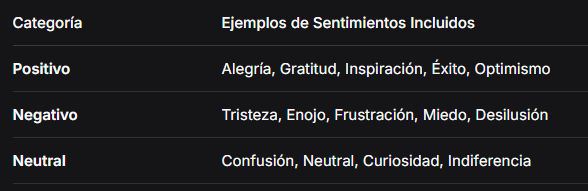

---
### 5. **<font color='lightgreen'>Estructura final de Dataset Unificado</font>**

El dataset exportado (dataset_listo_para_ML.csv) contiene:

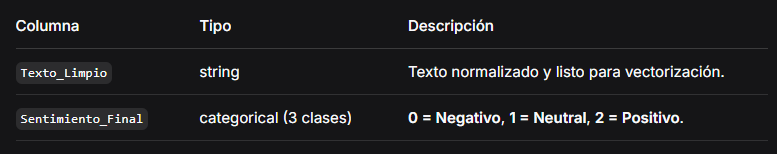


Estadísticas finales:

Registros totales: 3,272

Distribución:

- Negativo: 1,300 (39.7%)

- Positivo: 1,231 (37.6%)

- Neutral: 741 (22.7%)
---

In [361]:
df_unificado.rename({'Texto_Limpio':'texto'},axis=1,inplace=True)
df_unificado.rename({'Sentimiento_Final':'sentimiento'},axis=1,inplace=True)

In [362]:
df_unificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   texto        3272 non-null   object
 1   sentimiento  3272 non-null   object
dtypes: object(2)
memory usage: 51.3+ KB


In [363]:
df=pd.DataFrame(df_unificado)

In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   texto        3272 non-null   object
 1   sentimiento  3272 non-null   object
dtypes: object(2)
memory usage: 51.3+ KB


In [365]:
df

,texto,sentimiento
0,¡Acabo de adoptar a un lindo amigo peludo!??,positivo
1,¡Acabo de terminar un entrenamiento increible!??,positivo
2,¡Adoracion desbordante por un lindo cachorro r...,positivo
3,"¡Año nuevo, nuevos objetivos de fitness!??",positivo
4,¡Celebrando el cumpleaños de un amigo esta noc...,positivo
...,...,...
3267,No podemos vivir con miedo: ¡Manejen borrachos...,positivo
3268,"La vida es un constante, SIN MIEDO AL EXITO ????",positivo
3269,Esquizofrenia = mente dividida: Miedo a las re...,positivo
3270,"""Lo que mas miedo me da, es ver como desaparec...",positivo


In [366]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Descargar palabras vacías
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower() # Minúsculas
    texto = re.sub(r'[^\w\s]', '', texto) # Eliminar puntuación
    texto = " ".join([word for word in texto.split() if word not in stop_words]) # Quitar stopwords
    return texto

# Aplicar a tu dataset
df['texto'] = df['texto'].apply(limpiar_texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marely\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [367]:
df

,texto,sentimiento
0,acabo adoptar lindo amigo peludo,positivo
1,acabo terminar entrenamiento increible,positivo
2,adoracion desbordante lindo cachorro rescatado,positivo
3,año nuevo nuevos objetivos fitness,positivo
4,celebrando cumpleaños amigo noche,positivo
...,...,...
3267,podemos vivir miedo manejen borrachos dejen us...,positivo
3268,vida constante miedo exito,positivo
3269,esquizofrenia mente dividida miedo realidades ...,positivo
3270,mas miedo da ver desapareces mundo mas temo mundo,positivo


## Balanceo del Dataset, TF-IDF, Modelo, Métricas y Serialización

### Instalación de `imblearn`

Primero, necesitamos instalar la librería `imblearn`, que proporciona herramientas para manejar datasets desbalanceados, incluyendo la técnica SMOTE para sobremuestreo.

In [368]:
get_ipython().system('pip install imblearn')
print("Librería 'imblearn' instalada exitosamente.")

Librería 'imblearn' instalada exitosamente.


### Separación de Características y Target

Ahora, separaremos las características (el texto limpio) y la variable objetivo (el sentimiento) de nuestro DataFrame `df`. También mostraremos la distribución inicial de las clases para ver el desbalanceo.

In [369]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import joblib
import json
import pandas as pd

# Separar características (X) y variable objetivo (y)
X = df['texto']
y = df['sentimiento']

# Verificar la distribución inicial de las clases
print("Distribución inicial de las clases:")
print(y.value_counts())

Distribución inicial de las clases:
sentimiento
positivo    1375
negativo    1322
neutral      575
Name: count, dtype: int64


### División de Datos (Entrenamiento y Prueba) y Vectorización TF-IDF

Es crucial dividir el dataset en conjuntos de entrenamiento y prueba *antes* de aplicar SMOTE para evitar la fuga de datos (data leakage). Luego, transformaremos los textos en vectores numéricos usando `TfidfVectorizer`.

In [370]:
# Dividir el dataset en conjuntos de entrenamiento y prueba ANTES de aplicar SMOTE
X_train_unbalanced, X_test, y_train_unbalanced, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTamaño del conjunto de entrenamiento (desbalanceado): {len(X_train_unbalanced)} muestras")
print(f"Tamaño del conjunto de prueba: {len(X_test)} muestras")
print(f"Distribución de clases en el conjunto de entrenamiento (desbalanceado):\n{y_train_unbalanced.value_counts()}")
print(f"Distribución de clases en el conjunto de prueba:\n{y_test.value_counts()}")

# Inicializar TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limitando las características para eficiencia

# Ajustar y transformar X_train_unbalanced, y transformar X_test
X_train_tfidf_unbalanced = tfidf_vectorizer.fit_transform(X_train_unbalanced)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nVectorización TF-IDF completada en la división desbalanceada.")
print(f"Forma de X_train_tfidf_unbalanced: {X_train_tfidf_unbalanced.shape}")
print(f"Forma de X_test_tfidf: {X_test_tfidf.shape}")


Tamaño del conjunto de entrenamiento (desbalanceado): 2617 muestras
Tamaño del conjunto de prueba: 655 muestras
Distribución de clases en el conjunto de entrenamiento (desbalanceado):
sentimiento
positivo    1100
negativo    1057
neutral      460
Name: count, dtype: int64
Distribución de clases en el conjunto de prueba:
sentimiento
positivo    275
negativo    265
neutral     115
Name: count, dtype: int64

Vectorización TF-IDF completada en la división desbalanceada.
Forma de X_train_tfidf_unbalanced: (2617, 5000)
Forma de X_test_tfidf: (655, 5000)


### Balanceo del Conjunto de Entrenamiento con SMOTE

Ahora aplicaremos SMOTE solo al conjunto de entrenamiento vectorizado (`X_train_tfidf_unbalanced`) para balancear las clases, generando muestras sintéticas para las clases minoritarias.

In [371]:
# Inicializar SMOTE para balancear el conjunto de datos de ENTRENAMIENTO
smote = SMOTE(random_state=42)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf_unbalanced, y_train_unbalanced)

print("\nDistribución de clases después de SMOTE en los datos de entrenamiento:")
print(y_train.value_counts())

print(f"Forma de X_train_tfidf después de SMOTE: {X_train_tfidf.shape}")


Distribución de clases después de SMOTE en los datos de entrenamiento:
sentimiento
negativo    1100
neutral     1100
positivo    1100
Name: count, dtype: int64
Forma de X_train_tfidf después de SMOTE: (3300, 5000)


### Entrenamiento del Modelo de Regresión Logística

Entrenaremos un modelo de Regresión Logística utilizando los datos de entrenamiento balanceados y vectorizados.

In [372]:
# Entrenar el Modelo de Regresión Logística
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

print("\nModelo de Regresión Logística entrenado.")


Modelo de Regresión Logística entrenado.


### Evaluación del Modelo

Evaluaremos el rendimiento del modelo en el conjunto de prueba utilizando métricas clave como accuracy, precision, recall y F1-score.

In [373]:
# Evaluar el Modelo
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)

print("\nEvaluación del Modelo:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision (ponderada): {precision_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Recall (ponderado): {recall_score(y_test, y_pred, average='weighted'):.2f}")
print(f"F1-Score (ponderado): {f1_score(y_test, y_pred, average='weighted'):.2f}")
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))


Evaluación del Modelo:
Accuracy: 0.80
Precision (ponderada): 0.80
Recall (ponderado): 0.80
F1-Score (ponderado): 0.80

Reporte de Clasificación:
               precision    recall  f1-score   support

    negativo       0.89      0.86      0.88       265
     neutral       0.62      0.70      0.66       115
    positivo       0.80      0.78      0.79       275

    accuracy                           0.80       655
   macro avg       0.77      0.78      0.77       655
weighted avg       0.80      0.80      0.80       655



### Serialización del Modelo y Vectorizador

Guardaremos el modelo entrenado y el objeto `TfidfVectorizer` utilizando `joblib` para poder reutilizarlos más tarde en la API de predicción.

In [374]:
# Serializar el Modelo y el Vectorizador
joblib.dump(model, '/content/modelo_sentimientos.pkl')
joblib.dump(tfidf_vectorizer, '/content/vectorizador.pkl')

print("\nModelo y vectorizador guardados exitosamente en '/content/modelo_sentimientos.pkl' y '/content/vectorizador.pkl'.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/modelo_sentimientos.pkl'

### Prueba del Modelo con Salida JSON

Crearemos una función para probar el modelo con nuevas reseñas de texto. Esta función preprocesará el texto, lo vectorizará con el `TfidfVectorizer` guardado, realizará una predicción y devolverá el resultado en formato JSON, incluyendo la previsión y la probabilidad de la clase predicha.

In [ ]:
# Recargar el modelo y el vectorizador para probar (como si fuera una nueva sesión/API)
loaded_model = joblib.load('/content/modelo_sentimientos.pkl')
loaded_vectorizer = joblib.load('/content/vectorizador.pkl')

def predict_sentiment_json(text_review):
    # Preprocesamiento (igual que para los datos de entrenamiento)
    # Asumiendo que `pre_proccess_text` y `limpiar_texto` están definidos en celdas anteriores
    cleaned_text = pre_proccess_text(text_review)
    cleaned_text = limpiar_texto(cleaned_text)

    # Vectorizar el texto limpio
    text_vectorized = loaded_vectorizer.transform([cleaned_text])

    # Predecir el sentimiento
    prediction = loaded_model.predict(text_vectorized)[0]

    # Predecir las probabilidades
    probabilities = loaded_model.predict_proba(text_vectorized)[0]
    class_labels = loaded_model.classes_
    # Asegurar el mapeo correcto de probabilidades a etiquetas
    prob_dict = {label: round(prob * 100, 2) for label, prob in zip(class_labels, probabilities)}

    # Obtener la probabilidad de la clase predicha
    predicted_prob = prob_dict[prediction]

    result = {
        "prevision": prediction,
        "probabilidad": predicted_prob
    }
    return json.dumps(result, indent=4)

# Ejemplos de uso de la función de predicción
new_review1 = "Tengo hambre"
new_review2 = "mala actitud del personal"
new_review3 = "La situación es complicada, no sé qué pensar."

print(f"\nPredicción para '{new_review1}':")
print(predict_sentiment_json(new_review1))

print(f"\nPredicción para '{new_review2}':")
print(predict_sentiment_json(new_review2))

print(f"\nPredicción para '{new_review3}':")
print(predict_sentiment_json(new_review3))

### <font size=12 color=lightgreen>Exportación del modelo</font>

In [ ]:
from sklearn.pipeline import Pipeline
import joblib

# Creamos un Pipeline manual uniendo las dos piezas
pipeline_para_produccion = Pipeline([
    ('vectorizer', tfidf_vectorizer), # Primero transforma el texto a números
    ('classifier', model)             # Luego predice con esos números
])

# Probamos que funcione antes de exportar
test_text = ["Este es un ejemplo de prueba para ver si funciona el pipeline"]
prediccion = pipeline_para_produccion.predict(test_text)
print(f"Prueba del pipeline: {prediccion}")

# EXPORTAR EL ARCHIVO FINAL
# Este es el archivo que debes subir a la carpeta de tu microservicio
joblib.dump(pipeline_para_produccion, 'modelo_entrenado.joblib')

print("✅ Archivo 'modelo_entrenado.joblib' creado exitosamente. Úsalo en tu API.")